# Leer datasets

In [20]:
import pandas as pd
import numpy as np

moon = pd.read_csv('../../../data/sintetica/no separable/circle.csv')
moon.head()

,X1,X2,label
0,-0.281529,0.141190,1
1,-0.164164,0.986075,0
2,-0.271517,0.014948,1
3,-0.670347,-0.657977,0
4,-0.826468,0.594071,0


In [21]:
moon.drop(columns=['label'], inplace=True)

# Realizamos los clusters

In [22]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, SpectralClustering, AffinityPropagation, Birch, OPTICS, BisectingKMeans
from sklearn.mixture import GaussianMixture
n_clusters = 2
clustering_algorithms = {
    'KMeans': KMeans(n_clusters=n_clusters, random_state=42),
    'DBSCAN': DBSCAN(eps=0.2, min_samples=5),
    'AgglomerativeClustering': AgglomerativeClustering(n_clusters=n_clusters),
    'MeanShift': MeanShift(),
    'SpectralClustering': SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors'),
    'AffinityPropagation': AffinityPropagation(),
    'Birch': Birch(n_clusters=n_clusters),
    'OPTICS': OPTICS(min_samples=5, cluster_method='xi', xi=0.05),
    'BisectingKMeans': BisectingKMeans(n_clusters=n_clusters, random_state=42),
    'GaussianMixture': GaussianMixture(n_components=n_clusters, random_state=42)
}
results = {}
for name, algorithm in clustering_algorithms.items():
    try:
        algorithm.fit(moon)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        elif hasattr(algorithm, 'predict'):
            labels = algorithm.predict(moon)
        else:
            labels = algorithm.means_.argmax(axis=0)  # For GaussianMixture
        results[name] = labels
    except Exception as e:
        print(f"Error with {name}: {e}")

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


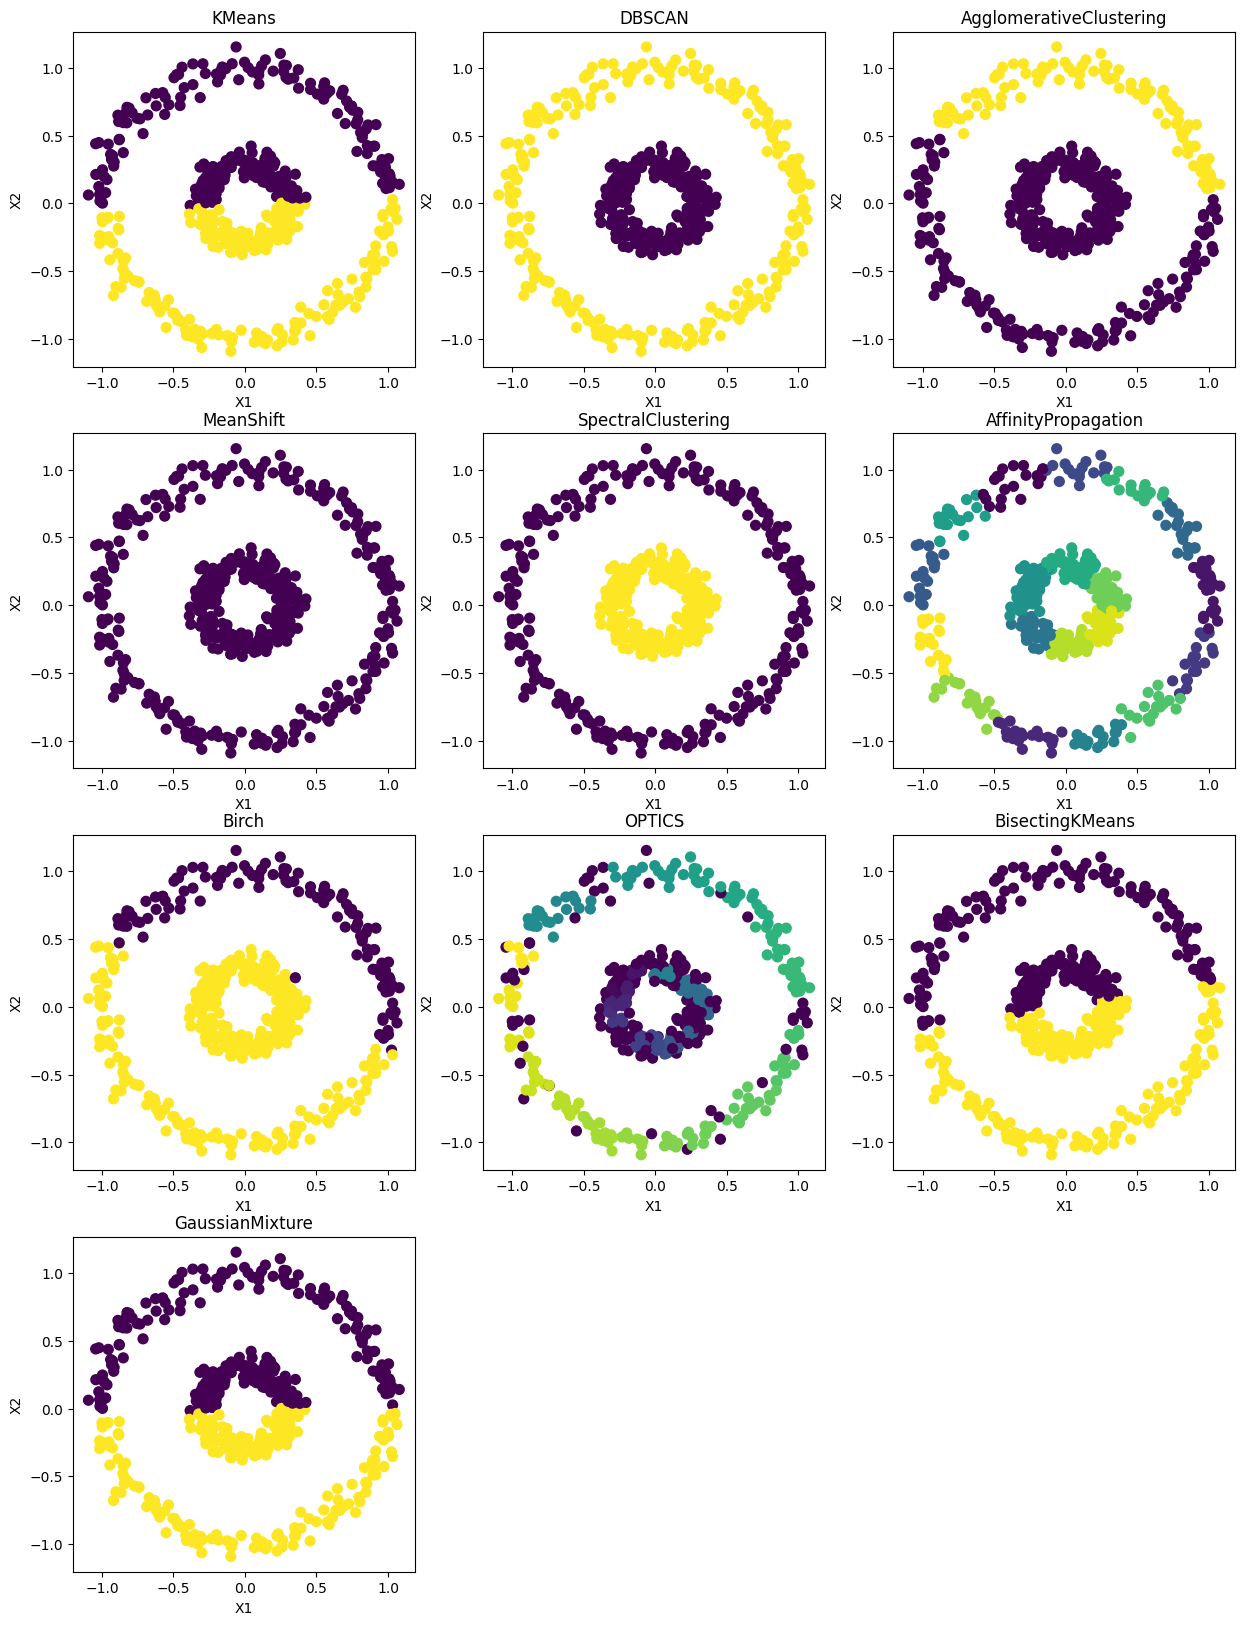

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))
for i, (name, labels) in enumerate(results.items(), 1):
    plt.subplot(4, 3, i)
    plt.scatter(moon.iloc[:, 0], moon.iloc[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(name)
    plt.xlabel(moon.columns[0])
    plt.ylabel(moon.columns[1])

In [24]:
#definimos dunn index
def dunn_index(data, labels):
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return 0.0

    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in range(len(unique_labels)):
        for j in range(i + 1, len(unique_labels)):
            cluster_i = data[labels == unique_labels[i]]
            cluster_j = data[labels == unique_labels[j]]
            inter_distance = np.linalg.norm(cluster_i.mean(axis=0) - cluster_j.mean(axis=0))
            inter_cluster_distances.append(inter_distance)

        intra_distance = np.mean([np.linalg.norm(data[labels == unique_label] - data[labels == unique_label].mean(axis=0)) for unique_label in unique_labels])
        intra_cluster_distances.append(intra_distance)

    dunn_index_value = min(inter_cluster_distances) / max(intra_cluster_distances)
    return dunn_index_value

In [25]:
#podrias generar una metrica en que se calcule el valor maximo de distancia (entre las menores distancias de cada punto con otro dentro del mismo cluster) dividido por el valor minimo de distancia entre cualquier punto de un cluster con otro punto de otro cluster
import numpy as np
from sklearn.metrics import pairwise_distances

def custom_metric(X, labels):
    X = np.array(X)
    distances = pairwise_distances(X)
    n = len(X)
    
    # Numerador: máximo de las mínimas distancias dentro del mismo cluster
    max_min_intra = -np.inf
    for i in range(n):
        same_cluster = (labels == labels[i])
        same_cluster[i] = False  # Exclude itself
        if np.any(same_cluster):
            min_dist = np.min(distances[i][same_cluster])
            max_min_intra = max(max_min_intra, min_dist)
    
    # Denominador: mínima distancia entre puntos de distintos clusters
    min_inter = np.inf
    for i in range(n):
        other_cluster = (labels != labels[i])
        if np.any(other_cluster):
            min_dist = np.min(distances[i][other_cluster])
            min_inter = min(min_inter, min_dist)

    M = max_min_intra / min_inter if min_inter != 0 else np.inf
    return 1 /( 1 + M)


In [26]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from permetrics import ClusteringMetric
def evaluate_clustering(data, labels):
    if len(set(labels)) < 2:
        return {
            'Silhouette Score': None,
            'Calinski-Harabasz Score': None,
            'Davies-Bouldin Score': None,
            'Dunn Index': None,
            'custom_metric': None,
            'dbcv': None
        }
    
    silhouette = silhouette_score(data, labels)
    calinski_harabasz = calinski_harabasz_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)
    dunn = dunn_index(data.values, labels)
    custom = custom_metric(data.values, labels)
    dbcv = ClusteringMetric(X=data.values, y_pred=labels).DBCVI()

    return {
        'Silhouette Score': silhouette,
        'Calinski-Harabasz Score': calinski_harabasz,
        'Davies-Bouldin Score': davies_bouldin,
        'Dunn Index': dunn,
        'custom_metric': custom,
        'dbcv': dbcv
    }
evaluation_results = {}
for name, labels in results.items():
    evaluation_results[name] = evaluate_clustering(moon, labels)
evaluation_df = pd.DataFrame(evaluation_results).T
evaluation_df = evaluation_df.rename(columns={
    'Silhouette Score': 'Silhouette',
    'Calinski-Harabasz Score': 'Calinski-Harabasz',
    'Davies-Bouldin Score': 'Davies-Bouldin',
    'Dunn Index': 'Dunn',
    'custom_metric': 'Custom Metric'
})
evaluation_df

/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dani/Documents/GitHub/Trabajo-dirigido-clustering/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:136: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv
KMeans,0.289088,224.816649,1.321656,0.084996,0.119447,0.918844
DBSCAN,0.207367,0.010515,191.227587,0.000658,0.78232,0.761152
AgglomerativeClustering,0.353494,175.794274,1.257392,0.096344,0.419065,0.827787
MeanShift,None,None,None,None,None,None
SpectralClustering,0.207367,0.010515,191.227587,0.000658,0.78232,0.761152
AffinityPropagation,0.4532,878.567394,0.59856,0.368583,0.039911,0.984724
Birch,0.349876,170.555802,1.39062,0.088407,0.00694,0.884541
OPTICS,0.069599,44.251085,1.183656,0.194533,0.005645,NaN
BisectingKMeans,0.28758,223.18357,1.325976,0.084682,0.065307,0.920525
GaussianMixture,0.289052,224.778665,1.321589,0.085,0.119447,0.918813


In [37]:
#elige los mejores 3 resultados ponderando el orden de cada métrica
def weighted_score(row):
    weights = {
        'Silhouette': 0.2,
        'Calinski-Harabasz': -0.2,
        'Davies-Bouldin': 0.2,  # Negativo porque queremos minimizar
        'Dunn': 0.2,
        'Custom Metric': 0.5 # Puedes ajustar este peso según su importancia
    }
    score = (row['Silhouette'] * weights['Silhouette'] +
                1/(1+row['Calinski-Harabasz']) * weights['Calinski-Harabasz'] +
                1/(1+row['Davies-Bouldin']) * weights['Davies-Bouldin'] +
                row['Dunn'] * weights['Dunn'] +
                row['Custom Metric'] * weights['Custom Metric'])
    return score
# Replace None values with 0 for scoring
evaluation_df_filled = evaluation_df.fillna(0)
evaluation_df_filled['Weighted Score'] = evaluation_df_filled.apply(weighted_score, axis=1)
top_3_algorithms = evaluation_df_filled.nlargest(3, 'Weighted Score')
top_3_algorithms

/tmp/ipykernel_41630/2114172724.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  evaluation_df_filled = evaluation_df.fillna(0)


,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn,Custom Metric,dbcv,Weighted Score
AgglomerativeClustering,0.353494,175.794274,1.257392,0.096344,0.419065,0.827787,0.386966
AffinityPropagation,0.453200,878.567394,0.598560,0.368583,0.039911,0.984724,0.309197
DBSCAN,0.207367,0.010515,191.227587,0.000658,0.782320,0.761152,0.235886


# Interpretar

In [38]:
import sys
sys.path.append('../../..')
from ripper import MultiClassRipperClassifier
from dsgd import DSClassifierMultiQ
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree as sk_tree

In [40]:
# interpretamos solo los mejores 3 resultados y guardamos los modelos
saved_models = {}
top_3_labels = {name: results[name] for name in top_3_algorithms.index}
top_3_data = moon.copy()
for name, labels in top_3_labels.items():
    n = len(np.unique(labels))
    X_train, X_test, y_train, y_test = train_test_split(top_3_data, labels, test_size=0.2, random_state=42)
    print(f'Processing {name} con {n} clusters...')
    
    # Ripper
    ripper = MultiClassRipperClassifier(random_state=43)
    ripper.fit(X_train, y_train)
    y_pred_ripper = ripper.predict(X_test)
    print(f'Ripper Accuracy for {name}: {accuracy_score(y_test, y_pred_ripper):.2f}')
    saved_models.setdefault(name, {})['ripper'] = ripper
    
    # Decision Tree
    dtree = DecisionTreeClassifier(random_state=42, max_depth=5)
    dtree.fit(X_train, y_train)
    dtree_pred = dtree.predict(X_test)
    print(f'Decision Tree Accuracy for {name}: {accuracy_score(y_test, dtree_pred):.2f}')
    saved_models[name]['dtree'] = dtree
    
    # DSGD
    ds = DSClassifierMultiQ(n, min_iter=20, max_iter=200, debug_mode=True, lossfn="MSE", num_workers=0, min_dloss=1e-7)
    X = X_train.to_numpy()
    losses, epoch, dt = ds.fit(X, y_train, add_single_rules=True, single_rules_breaks=3, add_mult_rules=False, column_names=X_train.columns)
    x_test = X_test.to_numpy()
    y_pred_ds = ds.predict(x_test)
    print(f'DSGD Accuracy for {name}: {accuracy_score(y_test, y_pred_ds):.2f}')
    saved_models[name]['ds'] = ds
    
    print('--' * 40)


Processing AgglomerativeClustering con 2 clusters...
Ripper Accuracy for AgglomerativeClustering: 0.97
Decision Tree Accuracy for AgglomerativeClustering: 0.97
Optimization started

Training time: 14.91s, epochs: 200

Least training loss reached: 0.053
DSGD Accuracy for AgglomerativeClustering: 0.96
--------------------------------------------------------------------------------
Processing AffinityPropagation con 19 clusters...
Ripper Accuracy for AffinityPropagation: 0.85
Decision Tree Accuracy for AffinityPropagation: 0.88
Optimization started

Training time: 6.08s, epochs: 68

Least training loss reached: 0.024
DSGD Accuracy for AffinityPropagation: 0.64
--------------------------------------------------------------------------------
Processing DBSCAN con 2 clusters...
Ripper Accuracy for DBSCAN: 1.00
Decision Tree Accuracy for DBSCAN: 1.00
Optimization started

Training time: 15.07s, epochs: 200

Least training loss reached: 0.056
DSGD Accuracy for DBSCAN: 0.98
--------------------

# Primer algoritmo

In [41]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[0]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X2=-0.13-0.00092] V [X2=<-0.77] V [X2=-0.24--0.13] V [X2=-0.37--0.24] V [X2=-0.77--0.37] V [X2=0.00092-0.13] V [X2=0.25-0.38^X1=-0.13-0.016] V [X2=0.13-0.25^X1=-0.24--0.13] V [X2=0.25-0.38^X1=0.016-0.14] V [X2=0.25-0.38^X1=0.14-0.28] V [X2=0.13-0.25^X1=-0.35--0.24] V [X2=0.13-0.25^X1=0.016-0.14] V [X2=0.25-0.38^X1=<-0.82] V [X2=0.13-0.25^X1=0.14-0.28] V [X2=0.13-0.25^X1=-0.13-0.016] V [X2=0.13-0.25^X1=<-0.82] V [X1=-0.24--0.13^X2=0.25-0.38] V [X2=0.13-0.25^X1=0.28-0.4]]

Reglas para clase: 1
[[X2=0.38-0.81^X1=0.4-0.82] V [X2=>0.81] V [X2=0.38-0.81^X1=-0.82--0.35] V [X1=>0.82^X2=0.38-0.81] V [X1=>0.82^X2=0.13-0.25] V [X1=>0.82^X2=0.25-0.38] V [X2=0.38-0.81] V [X1=>0.82^X2=0.00092-0.13]]


Decision Tree:


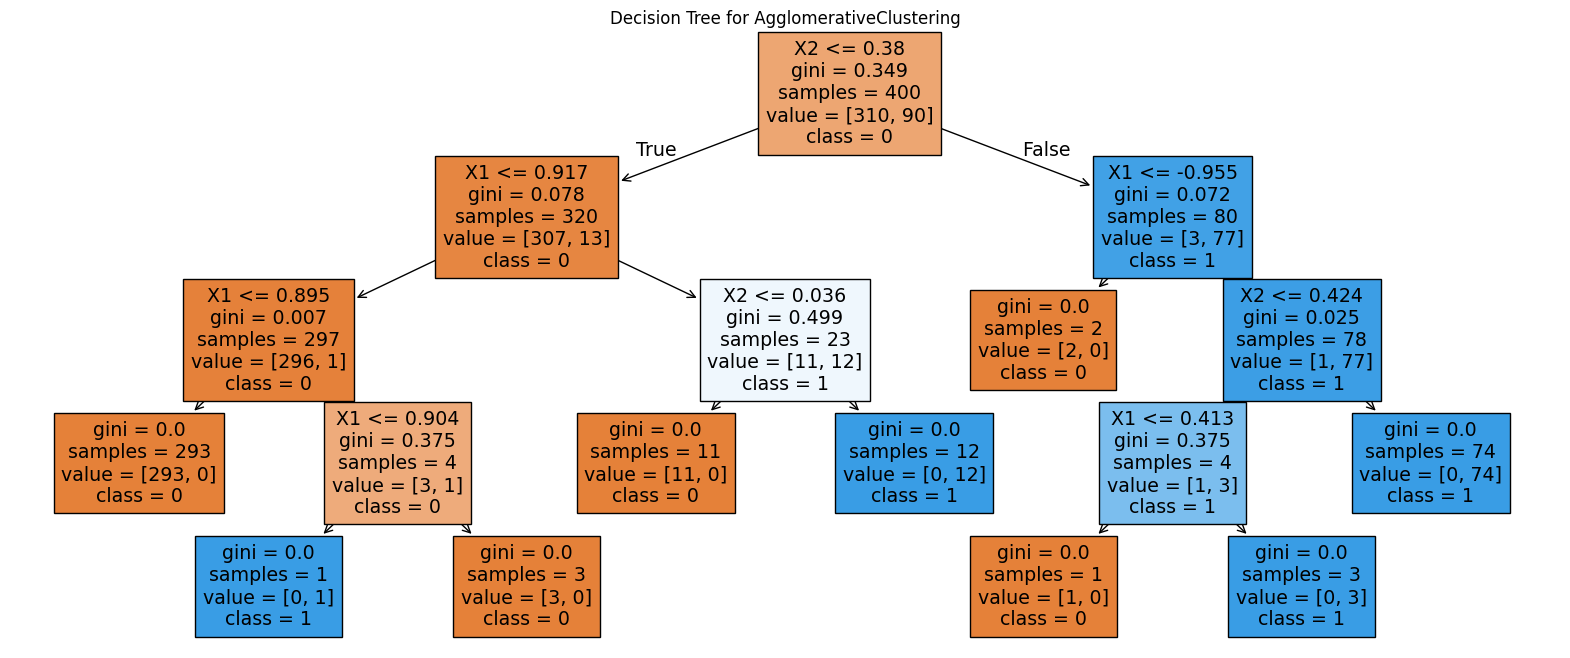

In [42]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=moon.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[0]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [43]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.735] R4: X2 < -0.355
			0: 0.735	1: 0.000	Unc: 0.265

	[0.711] R5: -0.355 < X2 < 0.001
			0: 0.711	1: 0.000	Unc: 0.289

	[0.648] R1: -0.341 < X1 < 0.018
			0: 0.648	1: 0.000	Unc: 0.352

	[0.595] R6: 0.001 < X2 < 0.358
			0: 0.595	1: 0.000	Unc: 0.405

	[0.548] R2: 0.018 < X1 < 0.377
			0: 0.548	1: 0.000	Unc: 0.452

	[0.445] R0: X1 < -0.341
			0: 0.445	1: 0.000	Unc: 0.555

Most important rules for class 1

	[0.815] R7: X2 > 0.358
			0: 0.000	1: 0.815	Unc: 0.185
--------------------------------------------------------------------------------


# Segundo algoritmo

In [44]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[1]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X2=>0.81^X1=-0.82--0.35] V [X2=>0.81^X1=-0.24--0.13] V [X1=-0.35--0.24^X2=>0.81] V [X2=0.38-0.81^X1=-0.35--0.24]]

Reglas para clase: 1
[[X1=>0.82^X2=0.13-0.25] V [X1=>0.82^X2=-0.13-0.00092] V [X1=>0.82^X2=0.25-0.38] V [X1=>0.82^X2=0.00092-0.13]]

Reglas para clase: 2
[[X2=<-0.77^X1=-0.13-0.016] V [X2=<-0.77^X1=-0.35--0.24] V [X2=<-0.77^X1=-0.82--0.35] V [X2=<-0.77^X1=-0.24--0.13]]

Reglas para clase: 3
[[X1=>0.82^X2=-0.77--0.37] V [X1=>0.82^X2=-0.37--0.24] V [X1=>0.82^X2=-0.24--0.13]]

Reglas para clase: 4
[[X2=>0.81^X1=0.016-0.14] V [X2=>0.81^X1=0.14-0.28] V [X2=>0.81^X1=-0.13-0.016]]

Reglas para clase: 5
[[X1=<-0.82^X2=0.25-0.38] V [X1=<-0.82^X2=0.00092-0.13] V [X1=<-0.82^X2=0.13-0.25]]

Reglas para clase: 6
[[X2=0.38-0.81^X1=>0.82] V [X2=0.38-0.81^X1=0.4-0.82]]

Reglas para clase: 7
[[X2=-0.24--0.13^X1=-0.35--0.24] V [X1=-0.24--0.13^X2=-0.24--0.13] V [X2=-0.13-0.00092^X1=-0.35--0.24] V [X1=-0.24--0.13^X2=-0.37--0.24] V [X1=-0.13-0.016^X2=-0.24

Decision Tree:


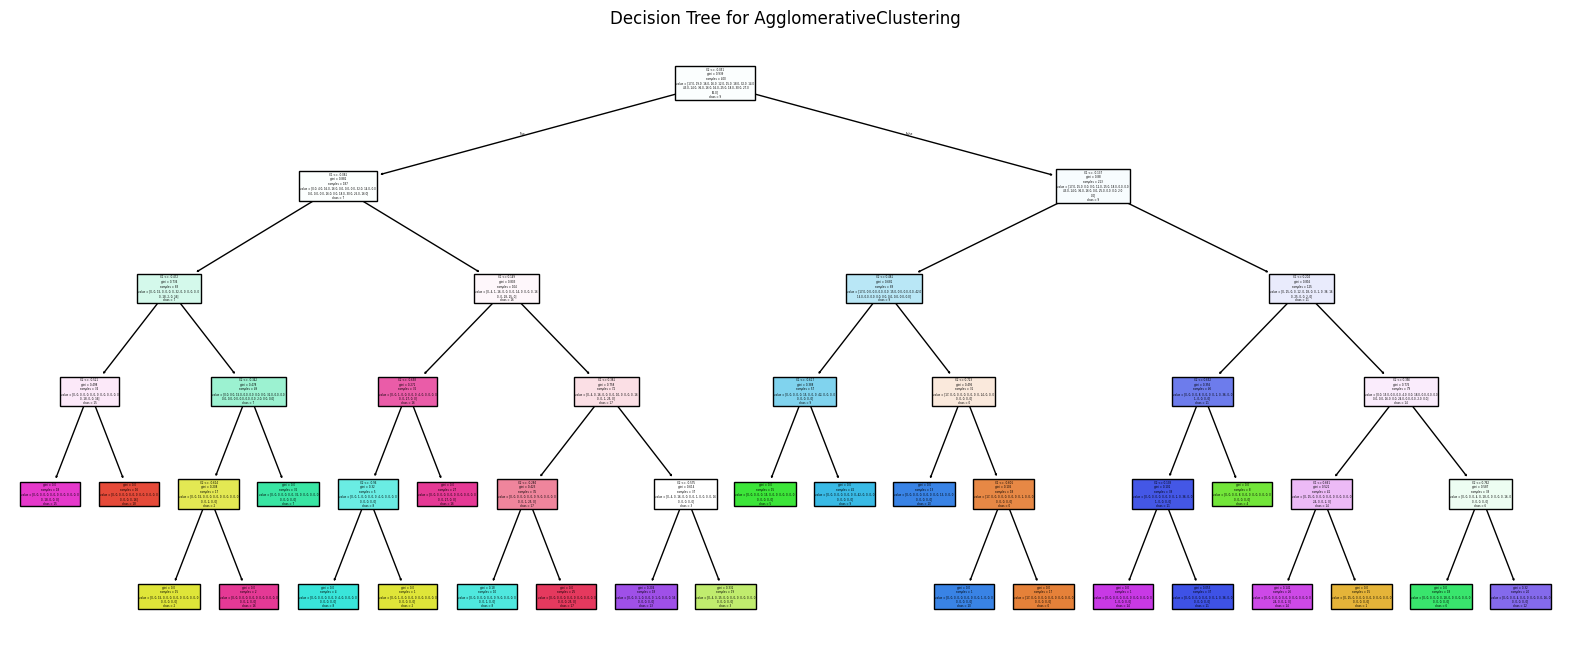

In [46]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=moon.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[1]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [47]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.426] R7: X2 > 0.358
			0: 0.182	1: 0.000	2: 0.008	3: 0.000	4: 0.191	5: 0.035	6: 0.191	7: 0.008	8: 0.000	9: 0.008	10: 0.180	11: 0.035	12: 0.159	13: 0.000	14: 0.000	15: 0.000	16: 0.000	17: 0.000	18: 0.000	Unc: 0.002

	[0.364] R0: X1 < -0.341
			0: 0.133	1: 0.000	2: 0.034	3: 0.002	4: 0.000	5: 0.213	6: 0.000	7: 0.003	8: 0.005	9: 0.008	10: 0.180	11: 0.000	12: 0.000	13: 0.005	14: 0.000	15: 0.188	16: 0.000	17: 0.000	18: 0.225	Unc: 0.004

Most important rules for class 1

	[0.484] R3: X1 > 0.377
			0: 0.000	1: 0.235	2: 0.000	3: 0.211	4: 0.000	5: 0.000	6: 0.220	7: 0.000	8: 0.000	9: 0.000	10: 0.000	11: 0.000	12: 0.123	13: 0.206	14: 0.004	15: 0.000	16: 0.000	17: 0.000	18: 0.000	Unc: 0.000

	[0.470] R6: 0.001 < X2 < 0.358
			0: 0.000	1: 0.221	2: 0.000	3: 0.000	4: 0.000	5: 0.213	6: 0.000	7: 0.000	8: 0.000	9: 0.217	10: 0.000	11: 0.184	12: 0.000	13: 0.000	14: 0.165	15: 0.000	16: 0.000	17: 0.000	18: 0.000	Unc: 0.000

	[0.335] R5: -0.355 < X2 < 0.001


# Tercer algoritmo

In [48]:
#interpretamos primer algoritmo
models = saved_models[top_3_algorithms.index[2]]
print('Ripper Rules:')
models['ripper'].print_rules()

Ripper Rules:

Reglas para clase: 0
[[X2=-0.37--0.24^X1=-0.13-0.016] V [X1=-0.35--0.24] V [X1=-0.24--0.13^X2=0.13-0.25] V [X1=0.016-0.14^X2=-0.37--0.24] V [X1=0.14-0.28^X2=-0.24--0.13] V [X1=0.14-0.28^X2=-0.13-0.00092] V [X1=0.28-0.4^X2=-0.13-0.00092] V [X1=-0.24--0.13^X2=-0.13-0.00092] V [X2=0.25-0.38^X1=-0.13-0.016] V [X1=0.016-0.14^X2=0.25-0.38] V [X2=0.00092-0.13] V [X2=-0.24--0.13^X1=-0.13-0.016] V [X1=-0.24--0.13^X2=0.25-0.38] V [X2=0.13-0.25^X1=0.016-0.14] V [X2=-0.24--0.13^X1=-0.24--0.13] V [X2=0.13-0.25^X1=-0.13-0.016] V [X2=-0.37--0.24^X1=-0.24--0.13] V [X1=0.14-0.28^X2=0.25-0.38] V [X2=-0.24--0.13^X1=0.28-0.4] V [X1=0.14-0.28^X2=-0.37--0.24] V [X2=0.13-0.25^X1=0.14-0.28] V [X1=0.28-0.4^X2=0.13-0.25] V [X1=0.016-0.14^X2=-0.24--0.13] V [X1=-0.13-0.016^X2=-0.77--0.37] V [X1=0.016-0.14^X2=0.38-0.81] V [X2=-0.24--0.13^X1=-0.82--0.35]]

Reglas para clase: 1
[[X1=<-0.82] V [X2=<-0.77] V [X1=>0.82] V [X2=>0.81] V [X2=0.38-0.81] V [X2=-0.77--0.37]]


Decision Tree:


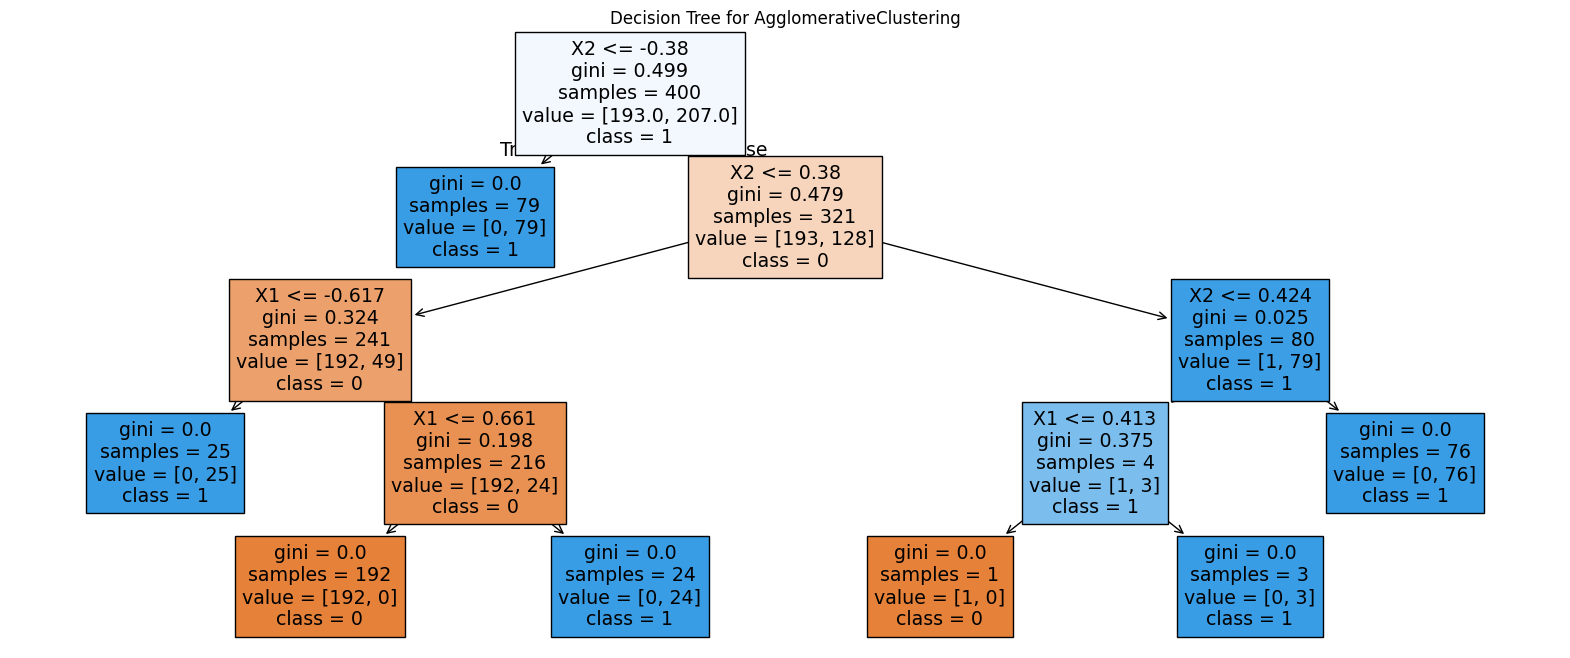

In [49]:
print('Decision Tree:')
plt.figure(figsize=(20, 8))
sk_tree.plot_tree(models['dtree'], filled=True, feature_names=moon.columns, class_names=np.unique(top_3_labels[top_3_algorithms.index[2]]).astype(str))
plt.title(f'Decision Tree for {top_3_algorithms.index[0]}')
plt.show()

In [50]:
print('DSGD Rules:')
models['ds'].print_most_important_rules(threshold=0.32)
print('--' * 40)

DSGD Rules:


Most important rules for class 0

	[0.621] R1: -0.341 < X1 < 0.018
			0: 0.621	1: 0.000	Unc: 0.379

	[0.571] R2: 0.018 < X1 < 0.377
			0: 0.571	1: 0.000	Unc: 0.429

	[0.546] R5: -0.355 < X2 < 0.001
			0: 0.546	1: 0.000	Unc: 0.454

	[0.499] R6: 0.001 < X2 < 0.358
			0: 0.499	1: 0.000	Unc: 0.501

Most important rules for class 1

	[0.814] R7: X2 > 0.358
			0: 0.000	1: 0.814	Unc: 0.186

	[0.772] R0: X1 < -0.341
			0: 0.000	1: 0.772	Unc: 0.228

	[0.749] R4: X2 < -0.355
			0: 0.000	1: 0.749	Unc: 0.251

	[0.690] R3: X1 > 0.377
			0: 0.000	1: 0.690	Unc: 0.310
--------------------------------------------------------------------------------
